## Name: Andrew Caide
### CSCI S-89C Deep Reinforcement Learning  
### Part II of Assignment 1

# Preface

In the example below, we have two classes, Environment and Agent. The Environment has 4 possible actions in all states (there are no states actually in this case but states can be easily added to the class) and regardless of the Agent's action the Environment generates a reward from normal distribution with mean 6 and variance 1. The Agent can choose one of the actions available to it and picks them at random. Then we run the experiment for 100 time steps by calling rewards_hist(100) and observe historical rewards.    

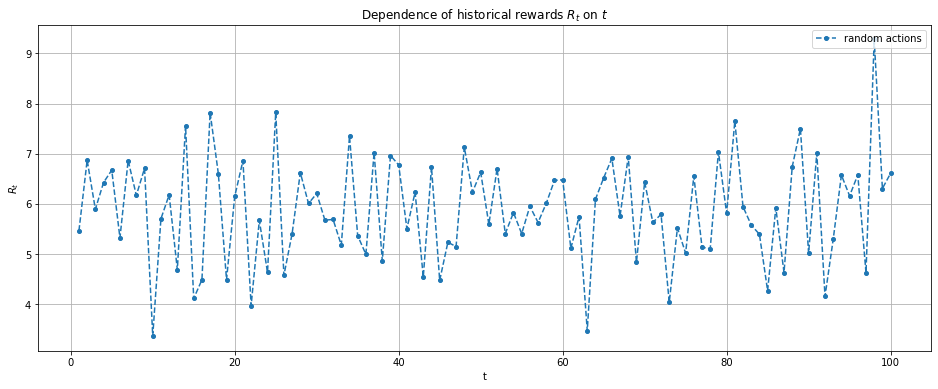

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt 

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        return random.gauss(6,1)


class Agent:
    def __init__(self):
        self.current_reward = 0.0

    def step(self, env):
        actions = env.admissible_actions()
        reward = env.get_reward(random.choice(actions))
        self.current_reward = reward
        
        
def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)

 
T = 100

plt.figure(figsize=(16,6))
plt.plot(range(1,T+1), rewards_hist(T), linestyle='--', marker='o', markersize=4, label='random actions')
plt.xlabel("t")
plt.ylabel("$R_t$")
plt.title('Dependence of historical rewards $R_t$ on $t$')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

## Problem 1 (5 points)

Please modify the Environment so that it generates rewards with mean 4, 6, 8, and 10 for actions 1, 2, 3, and 4, respectively. Please keep unit variance in all cases. Plot your historical rewards for 1, 2,..., T, where T = 100.

In [2]:
# Note: I am indicating my modifications with " # <--"; Sorry/Let me know if you'd like me to stop!

#P1: Modify actions to generate rewards with updated means
class New_Environment:
    def __init__(self):
        self.time = 1
        self.valid_actions = {1:4, 2:6, 3:8, 4:10} # <--
        
    def admissible_actions(self):
        return list(range(1,5))
    
    # The 'action' variable looks like it should've been removed.
    # Let's make use of it :)
    def get_reward(self, action):
        self.time += 1
        return random.gauss(self.valid_actions[action], 1) # <--
    
# Need to call the new environment
def rewards_hist(T = 10):
    env = New_Environment() # <--
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


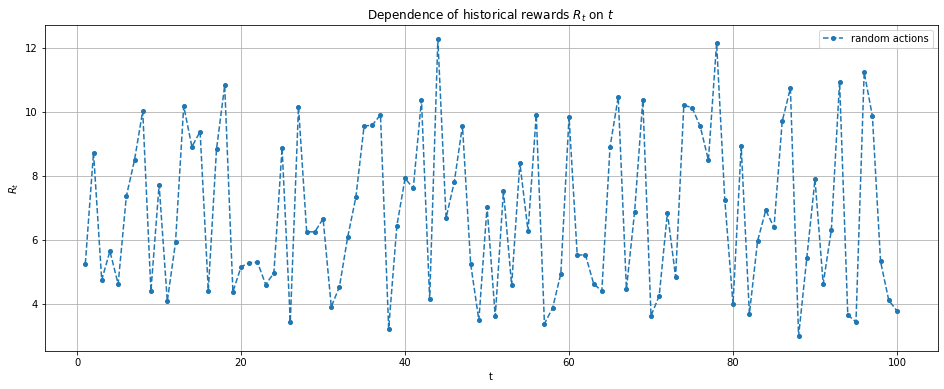

In [3]:
T = 100

plt.figure(figsize=(16,6))
plt.plot(range(1,T+1), rewards_hist(T), linestyle='--', marker='o', markersize=4, label='random actions')
plt.xlabel("t")
plt.ylabel("$R_t$")
plt.title('Dependence of historical rewards $R_t$ on $t$')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

In [4]:
# Looks fine, but let's check to make sure the calls are working as intended:
import pandas as pd

# Smarter Agent
class NoteKeeping_Agent:
    def __init__(self):
        self.current_reward = 0.0
        self.current_action = 0 # <--

    def step(self, env):
        actions = env.admissible_actions()
        self.current_action = random.choice(actions) # <-- 
        reward = env.get_reward(self.current_action) # <--
        self.current_reward = reward


def complete_hist(T = 10):
    env = New_Environment()
    agent = NoteKeeping_Agent()
    behavior = pd.DataFrame(columns = ("Action", "Reward")) # <--
    
    while env.time <= T:
        agent.step(env)
        behavior = behavior.append({"Action":agent.current_action, # <--
                                   "Reward":agent.current_reward},  # <--
                                   ignore_index = True) # <--
    return behavior

No handles with labels found to put in legend.


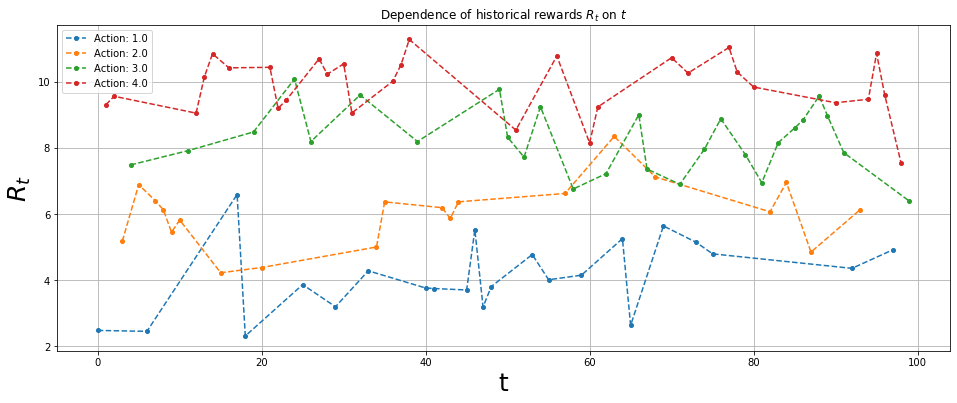

In [5]:
T = 100
performance = complete_hist(T) # <--
groups = performance.groupby('Action') # <--

# Plot
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('Dependence of historical rewards $R_t$ on $t$')
ax.set_ylabel("$R_t$",fontsize = 25.0)
ax.set_xlabel("t",fontsize = 25.0)
ax.legend(loc = 'upper right')
ax.grid(True)

for name, group in groups:
    ax.plot(group.index, group.Reward, marker='o', linestyle='--', ms=4, label = "Action: {}".format(name))
ax.legend()

plt.show()

In [6]:
# Check to make sure it looks right:

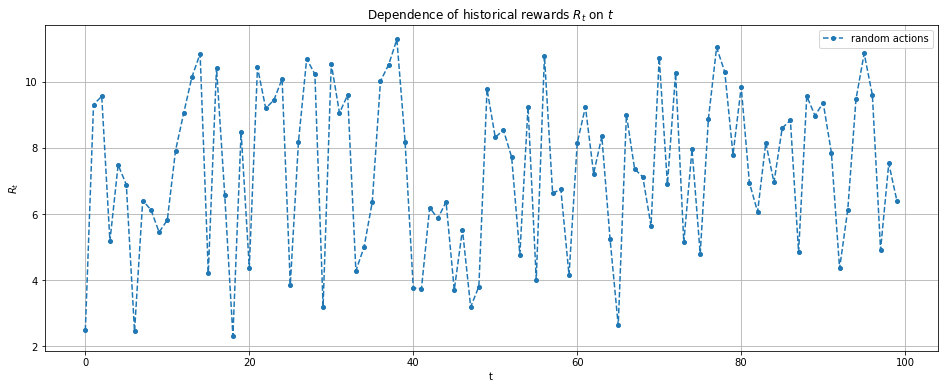

In [7]:
plt.figure(figsize=(16,6))
plt.plot(performance.index, performance.Reward, linestyle='--', marker='o', markersize=4, label='random actions')
plt.xlabel("t")
plt.ylabel("$R_t$")
plt.title('Dependence of historical rewards $R_t$ on $t$')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

## Problem 2 (10 points)

Modify the Agent so that it follows the $\varepsilon$-greedy selection method with $\varepsilon$ = 0.10 and the action value estimated by (2.3) of "Reinforcement Learning" by Sutton and Barto. Using this method and the Environment from Problem 1, plot observed historical rewards for 1, 2,..., T, where T = 100.

In [8]:
class e_Agent:
    def __init__(self, e = 0.10):
        self.current_reward = 0.0
        self.current_action = 0
        self.history = pd.DataFrame(columns = ("Action", "Mean_Reward", "Hits")) # <--
        self.history = self.history.set_index("Action") # <--
        self.e = e # <--
        

    # Helper function: update expectation value
    def update_expectation(self, new_reward, index):
        updated_sum = (self.history.loc[index,:].Mean_Reward * self.history.loc[index,:].Hits) +  new_reward
        updated_mean = updated_sum / (self.history.loc[index,:].Hits + 1)
        return updated_mean
        
    # First each step is sampled
    # The step with the highest Mean Reward is selected with a 90% chance 
    def step_carefully(self, env, test_all_options = True):
        
        # Run once
        actions = env.admissible_actions()
        if len(self.history.index) < len(actions) & test_all_options:
            for action in actions:
                self.current_action = int(action)
                self.current_reward = env.get_reward(self.current_action)
                self.history.loc[self.current_action,:] = [self.current_reward, 1]
        
        # Roll the dice, check if action has been done
        else:
            roll = random.uniform(0, 1)
            
            # If rolled <10% (or completely new run), randomly do something else
            if roll <= self.e or len(self.history.index) == 0:
                self.current_action = random.choice(actions)
                self.current_reward = env.get_reward(self.current_action)
                
                if self.current_action in self.history.index:
                    new_mean_reward = self.update_expectation(self.current_reward, self.current_action)
                    self.history.loc[self.current_action,:] = [new_mean_reward, self.history.loc[self.current_action,"Hits"]+1]
                else:
                    self.history.loc[self.current_action,:] = [self.current_reward, 1]
            
            # Else, run e-greedy operation 
            else: 
                best_reward_sofar = self.history.Mean_Reward == max(self.history.Mean_Reward)
                self.current_action = self.history[best_reward_sofar].index.values[0]
                self.current_reward = env.get_reward(self.current_action)
                new_mean_reward = self.update_expectation(self.current_reward, self.current_action)
                self.history.loc[self.current_action,:] = [new_mean_reward, self.history.loc[self.current_action,"Hits"]+1]

In [9]:
def e_hist(T = 10, test_all_operations = True):
    env = New_Environment()
    agent = e_Agent()
    behavior = pd.DataFrame(columns = ("Action", "Reward")) # <--
    
    while env.time <= T:
        agent.step_carefully(env, test_all_operations)
        behavior = behavior.append({"Action":agent.current_action, # <--
                                   "Reward":agent.current_reward},  # <--
                                   ignore_index = True) # <--
    return [behavior, agent.history]

(array([19.,  0.,  0., 24.,  0.,  0., 56.,  0.,  0.,  1.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

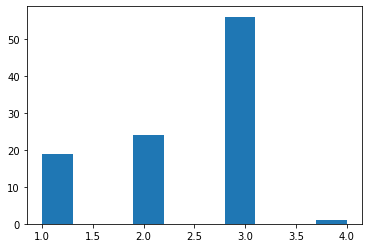

In [10]:
T = 100
performance = e_hist(T) # <--
plt.hist(performance[0].Action)

In [11]:
# check the history:
performance[1]

,Mean_Reward,Hits
Action,,
1,3.8045,19
2,5.86288,24
3,8.05031,56
4,7.63651,1


In [12]:
# I ran this for 1k rolls to *really* make sure the probability worked out. 
# We should roughly expect 90% + ~2.5% (total: 925 at 4.0 for 1000 rolls)
# It checks out.

(array([17.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0., 80.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

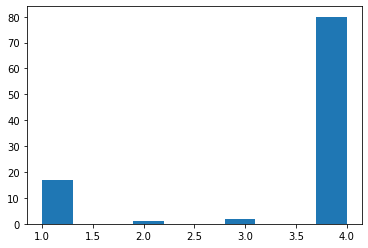

In [13]:
# But what if we don't scan all the operations first? 

T = 100
performance = e_hist(T, test_all_operations = False) # <--
plt.hist(performance[0].Action)

In [14]:
performance[1]

,Mean_Reward,Hits
Action,,
1,3.86499,17
4,10.0092,80
2,6.99412,1
3,9.359,2


In [15]:
# Now it's much more random, as expected!

## Problem 3 (5 points)

Run the algorithm obtained in Problem 2 for 200 times (i.e. for 200 epochs) for T = 1000, and compute the observed average reward for each time t. Plot the average reward from those 200 epochs for 1, 2,..., T. Please notice that T = 1000 this time.

In [16]:
# I'm not 100% sure what this problem is trying to do

def run_e(epochs = 200, T = 1000, test_all_operations = False):
    
    epoch_results = pd.DataFrame()
    for epoch in list(range(epochs)):
        run = e_hist(T, test_all_operations)[0]
        run['Epoch'] = epoch
        run['T'] = run.index
        epoch_results = epoch_results.append(run, ignore_index = True)
        if epoch % 25 == 0:
            print("Finished epoch {}".format(epoch))
    return epoch_results
    

In [17]:
run_e(epochs = 2, T = 10)

Finished epoch 0


,Action,Reward,Epoch,T
0,1.0,4.245571,0,0
1,3.0,7.851577,0,1
2,1.0,5.833117,0,2
3,3.0,8.299043,0,3
4,3.0,8.002280,0,4
5,3.0,5.971593,0,5
6,3.0,7.250592,0,6
7,3.0,7.645113,0,7
8,3.0,7.127782,0,8
9,2.0,6.270055,0,9


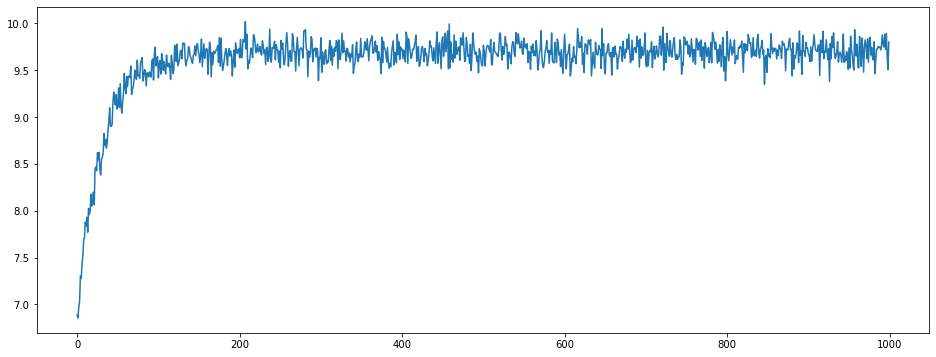

In [18]:
#                       a bit confused
# We're being asked to plot the average results for the 200 epochs by T (1-1000). 
# To do this I am going to group-by T and take the average reward. Each T will have 200 samples. 

average_reward = problem_3.groupby('T')['Reward'].mean()
plt.figure(figsize=(16,6))
plt.plot(average_reward.index, average_reward.T)

plt.show()

In [19]:
average_reward = pd.DataFrame(average_reward)
average_reward['T'] = average_reward.index

In [20]:
# Let's compare to a solution where the machine tests all 4 options first
problem_3_tao = run_e(epochs = 200, T = 1000, test_all_operations = True)

Finished epoch 0
Finished epoch 25
Finished epoch 50
Finished epoch 75
Finished epoch 100
Finished epoch 125
Finished epoch 150
Finished epoch 175


In [34]:
average_reward_tao = pd.DataFrame(problem_3_tao.groupby('T')['Reward'].mean())
average_reward_tao['T'] = average_reward_tao.index
average_reward['initial_state'] = "Blind"
average_reward_tao['initial_state'] = "Tested All Options"
average_reward = average_reward.append(average_reward_tao, ignore_index = True)
print(average_reward.head(5))
print(average_reward.tail(5))
print("\nExpecated Reward: {}".format(average_reward[average_reward.initial_state == "Blind"].Reward.mean()))

     Reward  T initial_state
0  6.887399  0         Blind
1  6.854904  1         Blind
2  6.973480  2         Blind
3  7.031207  3         Blind
4  7.305679  4         Blind
        Reward    T       initial_state
9995  9.660189  995  Tested All Options
9996  9.788223  996  Tested All Options
9997  9.638613  997  Tested All Options
9998  9.707754  998  Tested All Options
9999  9.553212  999  Tested All Options

Expecated Reward: 9.630233087546289


No handles with labels found to put in legend.


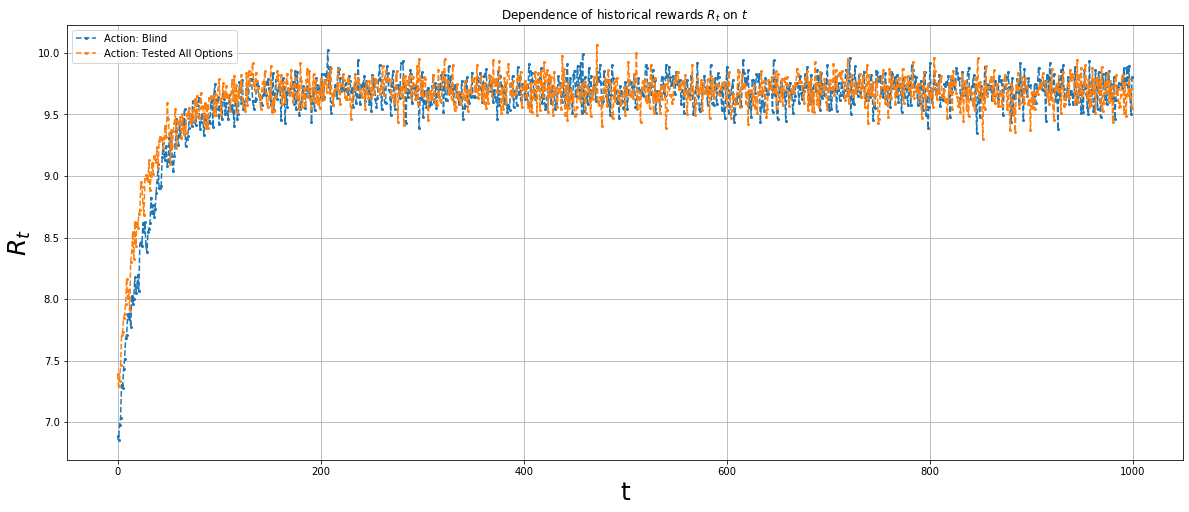

In [22]:
# Plot
groups = average_reward.groupby('initial_state') # <--
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Dependence of historical rewards $R_t$ on $t$')
ax.set_ylabel("$R_t$",fontsize = 25.0)
ax.set_xlabel("t",fontsize = 25.0)
ax.legend(loc = 'upper right')
ax.grid(True)

for name, group in groups:
    ax.plot(group['T'], group.Reward, marker='o', linestyle='--', ms=2, label = "Action: {}".format(name))
ax.legend()

In [23]:
# It looks like by testing all the options initially, we can arrive at the optimal choice sooner
# After T=100 both solutions arive at the same optimum choice. Variance is the same as well. 

No handles with labels found to put in legend.


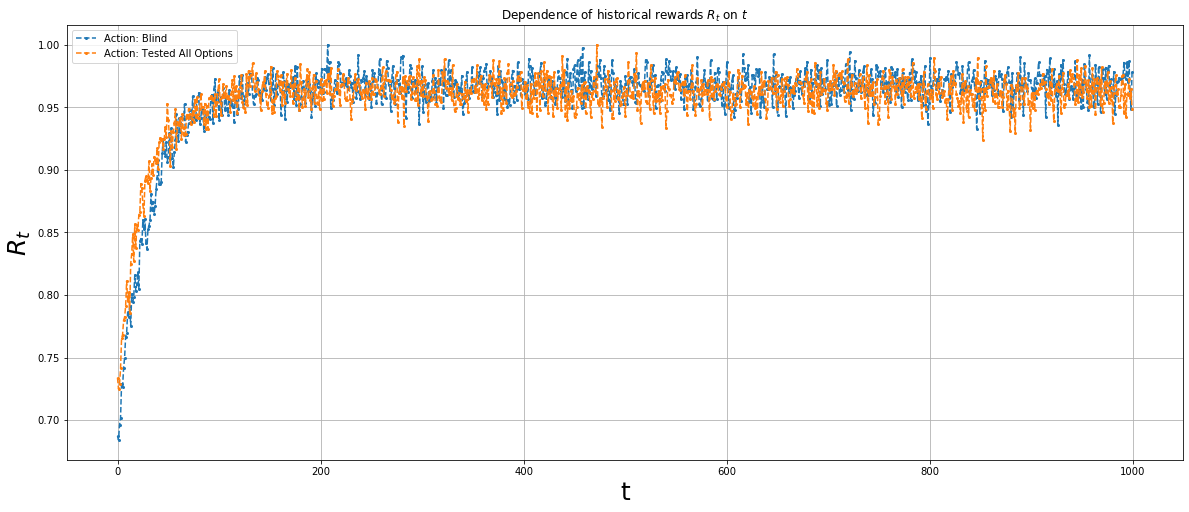

In [26]:
# Normalized: 

fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Dependence of historical rewards $R_t$ on $t$')
ax.set_ylabel("$R_t$",fontsize = 25.0)
ax.set_xlabel("t",fontsize = 25.0)
ax.legend(loc = 'upper right')
ax.grid(True)
for name, group in groups:
    ax.plot(group['T'], group.Reward/group.Reward.max(), marker='o', linestyle='--', ms=2, label = "Action: {}".format(name))
ax.legend()